In [3]:
# Import library yang diperlukan
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
# Path dataset
base_dir = 'dataset'  # Path folder dataset asli

In [5]:
# Membagi dataset ke dalam train, val, test (80% train, 10% val, 10% test)
splitfolders.ratio(base_dir,
                   output="dataset_final",
                   seed=1337,
                   ratio=(.8, .1, .1))

In [6]:
# Path dataset setelah split
train_img_path = 'dataset_final/train'
val_img_path = 'dataset_final/val'
test_img_path = 'dataset_final/test'

In [8]:
# Cek nama kelas (folder)
class_names = os.listdir(train_img_path)
print(f"Classes: {class_names}")

Classes: ['ripe', 'unripe']


In [9]:
# Data Augmentation untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi piksel ke [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
# Validasi dan test set hanya menggunakan normalisasi
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
# Menggunakan flow_from_directory untuk memuat dataset
train_data = train_datagen.flow_from_directory(
    train_img_path,  # Path ke data training
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_img_path,  # Path ke data validasi
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_img_path,  # Path ke data uji
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 1472 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 185 images belonging to 2 classes.


In [13]:

# Fungsi untuk membuat model CNN
def create_model(input_shape):
    model = Sequential()
    
    # Layer konvolusi dan pooling
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten dan fully connected layer
    model.add(Flatten())
    model.add(Dropout(0.5))  # Dropout untuk regularisasi
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer untuk klasifikasi biner
    
    # Kompilasi model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
# Membuat model
input_shape = (150, 150, 3)  # Input shape untuk gambar RGB 150x150
model = create_model(input_shape)


In [15]:
# Callback untuk early stopping dan learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [16]:
# Melatih model
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20
46/46 [==============================] - 38s 792ms/step - loss: 0.5637 - accuracy: 0.6793 - val_loss: 0.4193 - val_accuracy: 0.7935 - lr: 0.0010
Epoch 2/20
46/46 [==============================] - 27s 587ms/step - loss: 0.3144 - accuracy: 0.8709 - val_loss: 0.2409 - val_accuracy: 0.9293 - lr: 0.0010
Epoch 3/20
46/46 [==============================] - 27s 576ms/step - loss: 0.2369 - accuracy: 0.9042 - val_loss: 0.1760 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 4/20
46/46 [==============================] - 27s 580ms/step - loss: 0.2042 - accuracy: 0.9327 - val_loss: 0.1234 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 5/20
46/46 [==============================] - 27s 584ms/step - loss: 0.1696 - accuracy: 0.9429 - val_loss: 0.1130 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 6/20
46/46 [==============================] - 27s 584ms/step - loss: 0.1540 - accuracy: 0.9497 - val_loss: 0.1414 - val_accuracy: 0.9511 - lr: 0.0010
Epoch 7/20
46/46 [==============================] - 27s 582ms/st

In [17]:
# Evaluasi model pada data uji
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")


6/6 [==============================] - 2s 303ms/step - loss: 0.0398 - accuracy: 0.9784
Test Loss: 0.0398
Test Accuracy: 97.84%


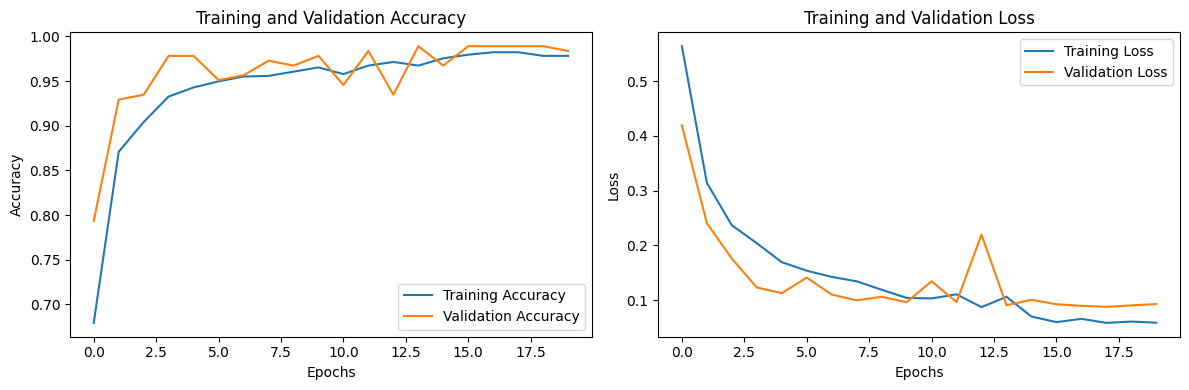

In [18]:
# Visualisasi hasil pelatihan
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 101ms/step


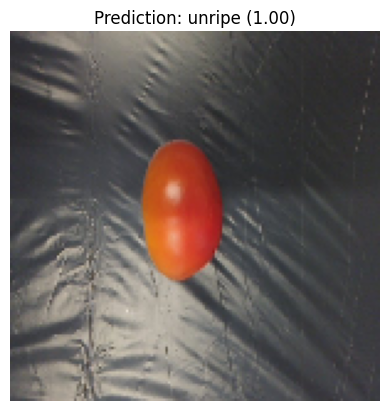

The predicted class is: unripe


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Fungsi untuk memuat dan memprediksi gambar
def predict_image(img_path, model, class_names):

    # Load gambar dan preprocessing
    img = image.load_img(img_path, target_size=(150, 150))  # Sesuaikan ukuran dengan input model
    img_array = image.img_to_array(img)  # Konversi ke array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array /= 255.0  # Normalisasi seperti pada data training

    # Prediksi menggunakan model
    prediction = model.predict(img_array)
    class_idx = 0 if prediction < 0.5 else 1  # Threshold 0.5 untuk klasifikasi biner
    class_name = class_names[class_idx]
    
    # Menampilkan gambar
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {class_name} ({prediction[0][0]:.2f})")
    plt.show()
    
    return class_name

# Contoh penggunaan
img_path = 'unripe.jpg'  # Ganti dengan path ke gambar Anda
predicted_class = predict_image(img_path, model, class_names)
print(f"The predicted class is: {predicted_class}")
